In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import spectools.models.models as mdl
import handytools.visualizer as vis
import handytools.navigator as nav
from copy import deepcopy
from spectools.stimulus.dataloader import get_50000_images
from spectools.responses import get_response_wrapper
from spectools.stimulus.wyeth import get_stimulus
from spectools.responses import get_response_wrapper
from spectools.metrics.metrics import responsive
from spectools.models.models import AN_layer, VGG16b_layer, ResNet18_layer

In [2]:
def get_prs(R_fills, R_outlines, hkeys, verbose=False):
    prs = {}
    respdic = {}
    for hkey in hkeys:
        R_fill = R_fills[hkey]
        R_outline = R_outlines[hkey]

        prs[hkey] = np.array([])
        respdic[hkey] = []
        
        for unit in range(R_fill.shape[0]):
            resp = responsive(R_fill[unit]) and responsive(R_outline[unit])
            if resp:
                pr = np.corrcoef(R_fill[unit], R_outline[unit])[0][1]
                prs[hkey] = np.append(prs[hkey], pr)
                respdic[hkey].append(int(unit))
            else:
                prs[hkey] = np.append(prs[hkey], np.nan)
                if verbose: print(f"Layer {hkey}, unit {unit} not responsive!")
    return prs, respdic

def linear_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept
    return x, y_pred

## AlexNet

In [3]:
# params
mtype = "AN"
seed = 42
np.random.seed(seed)

In [4]:
# define input
B = 200
random_idxs = np.random.choice(range(50000), B)
dataset = get_50000_images(random_idxs)
X = [dataset[idx].unsqueeze(0) for idx in range(B)]
X = torch.vstack(X)

# define models
if mtype == "AN": mfunc = mdl.get_alexnet; ldic = mdl.AN_layer
elif mtype == "VGG16": mfunc = mdl.get_vgg16; ldic = mdl.VGG16_layer
elif mtype == "VGG16b": mfunc = mdl.get_vgg16b; ldic = mdl.VGG16b_layer
hkeys = list(ldic.keys())[:-3]
model = mfunc(hidden_keys=hkeys)

In [5]:
# permutation
permts = [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]

Rcs_all = {}
for hkey in hkeys: Rcs_all[hkey] = [] 

for permt in permts:
    X_copy = deepcopy(X)
    X_permt = X_copy[:, permt]

    permt_str = ":".join([str(i) for i in permt])
    fname = lambda hkey: f"hkey={hkey}_rotatecolor_permt={permt_str}_seed={seed}.npy"
    Rcs = get_response_wrapper(hkeys, X_permt, fname, mtype=mtype, save=True) # key=hkey, value.shape=(#units, B)

    for hkey in hkeys:
        Rcs_all[hkey].append([Rcs[hkey]])

colordic = {}
for hkey in hkeys:
    Rcs = Rcs_all[hkey] = np.vstack(Rcs_all[hkey]) # value.shape = (6, #units, B)
    base = Rcs[0].std(axis=1) # shape = (#units,)
    color_indices = Rcs.std(axis=0).mean(axis=1)/base # shape = (#units,)
    colordic[hkey] = color_indices

# for sanity check
print(Rcs.shape, base.shape, color_indices.shape)

(6, 256, 200) (256,) (256,)


In [6]:
# get foi response
xn, sz, lw, fg, bg = 227, 50, 1.5, 1.0, 0.0
fill = get_stimulus(1, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=1_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_fills = get_response_wrapper(hkeys, fill, fname, mtype=mtype)
outline = get_stimulus(0, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=0_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_outlines = get_response_wrapper(hkeys, outline, fname, mtype=mtype)
prs_an_foi, resp = get_prs(R_fills, R_outlines, hkeys)

In [7]:
fig = plt.figure(figsize=(3*3, 2*3))

pos = ["ll"]*len(hkeys)
for i in range(len(hkeys)):
    hkey = hkeys[i]
    foi = prs_an_foi[hkey][resp[hkey]]
    ti = np.array(colordic[hkey])[resp[hkey]]
    x, y = np.log(ti), np.arctanh(foi)
    pr = np.corrcoef(x, y)[0][1]
    coors = vis.get_location(pos[i], [min(x), max(x)], [min(y), max(y)])
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.scatter(x, y, color="k", s=10)
    ax.plot(*linear_fit(x, y), color="b", linestyle="--")
    ax.set_title(AN_layer[hkey])
    vis.add_textbox(f"\u03C1 = {round(pr, 2)}", *coors, ax=ax, alpha=0.5)

vis.common_label(fig, "log(CI)", "arctanh(FOI)")
plt.suptitle("FOI v CI for AlexNet")
plt.tight_layout()
vis.savefig("ci_AN.png", folders=["summary_230526"])

<Figure size 900x600 with 0 Axes>

In [8]:
# Find specific unit

hkey = 6
foi = prs_an_foi[hkey][resp[hkey]]
ti = np.array(colordic[hkey])[resp[hkey]]

units = np.where((foi > 0.8) & (ti < 0.15))[0]
print(units)
nav.npsave(units, nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_unitsCiMin.npy")

units = np.where((foi < 0.3))[0]
print(units)
nav.npsave(units, nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_unitsCiMax.npy")

[13 32 36 56 57 58 66 84]
[15 21 79]


## VGG16

In [9]:
# params
mtype = "VGG16b"
seed = 42
np.random.seed(seed)

In [10]:
# define input
B = 200
random_idxs = np.random.choice(range(50000), B)
dataset = get_50000_images(random_idxs)
X = [dataset[idx].unsqueeze(0) for idx in range(B)]
X = torch.vstack(X)

# define models
if mtype == "AN": mfunc = mdl.get_alexnet; ldic = mdl.AN_layer
elif mtype == "VGG16": mfunc = mdl.get_vgg16; ldic = mdl.VGG16_layer
elif mtype == "VGG16b": mfunc = mdl.get_vgg16b; ldic = mdl.VGG16b_layer
hkeys = list(ldic.keys())[:-3]
model = mfunc(hidden_keys=hkeys)

In [11]:
# permutation
permts = [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]

Rcs_all = {}
for hkey in hkeys: Rcs_all[hkey] = [] 

for permt in permts:
    X_copy = deepcopy(X)
    X_permt = X_copy[:, permt]

    permt_str = ":".join([str(i) for i in permt])
    fname = lambda hkey: f"hkey={hkey}_rotatecolor_permt={permt_str}_seed={seed}.npy"
    Rcs = get_response_wrapper(hkeys, X_permt, fname, mtype=mtype, save=True) # key=hkey, value.shape=(#units, B)

    for hkey in hkeys:
        Rcs_all[hkey].append([Rcs[hkey]])

colordic = {}
for hkey in hkeys:
    Rcs = Rcs_all[hkey] = np.vstack(Rcs_all[hkey]) # value.shape = (6, #units, B)
    base = Rcs[0].std(axis=1) # shape = (#units,)
    color_indices = Rcs.std(axis=0).mean(axis=1)/base # shape = (#units,)
    colordic[hkey] = color_indices

/tmp/ipykernel_309587/1627143141.py:22: RuntimeWarning: divide by zero encountered in divide
  color_indices = Rcs.std(axis=0).mean(axis=1)/base # shape = (#units,)
/tmp/ipykernel_309587/1627143141.py:22: RuntimeWarning: invalid value encountered in divide
  color_indices = Rcs.std(axis=0).mean(axis=1)/base # shape = (#units,)


In [12]:
# get foi response
xn, sz, lw, fg, bg = 227, 50, 1.5, 1.0, 0.0
fill = get_stimulus(1, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=1_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_fills = get_response_wrapper(hkeys, fill, fname, mtype=mtype)
outline = get_stimulus(0, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=0_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_outlines = get_response_wrapper(hkeys, outline, fname, mtype=mtype)
prs_an_foi, resp = get_prs(R_fills, R_outlines, hkeys)

/home2/belleliu/anaconda3/envs/arti3/lib/python3.10/site-packages/numpy/lib/function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


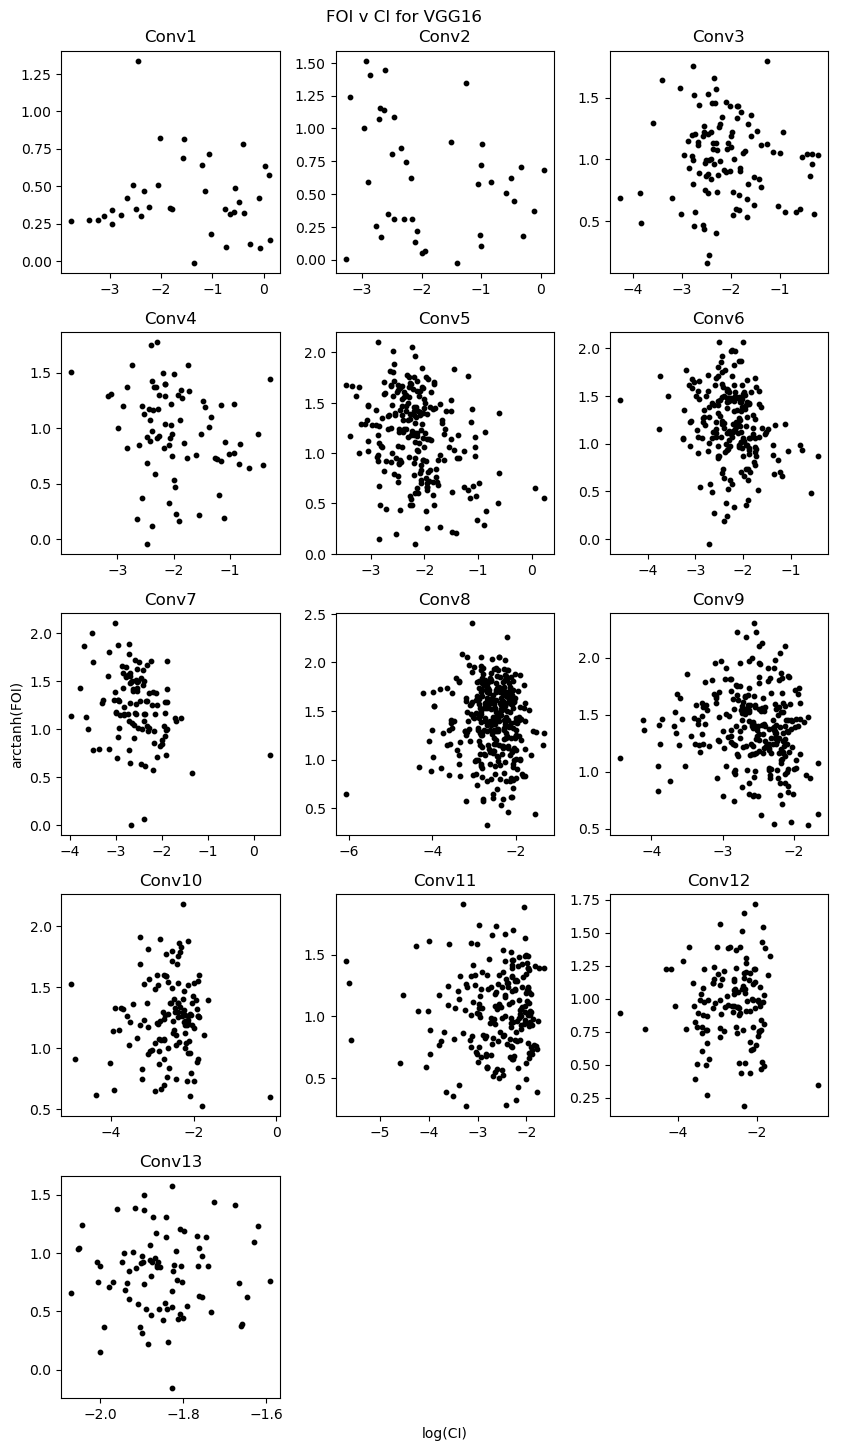

In [13]:
fig = plt.figure(figsize=(3*3, 5*3))

pos = ["ll"]*len(hkeys)
for i in range(len(hkeys)):
    hkey = hkeys[i]
    foi = prs_an_foi[hkey][resp[hkey]]
    ti = np.array(colordic[hkey])[resp[hkey]]
    x, y = np.log(ti), np.arctanh(foi)
    pr = np.corrcoef(x, y)[0][1]
    coors = vis.get_location(pos[i], [min(x), max(x)], [min(y), max(y)])
    
    ax = fig.add_subplot(5, 3, i+1)
    ax.scatter(x, y, color="k", s=10)
    ax.set_title(VGG16b_layer[hkey])

vis.common_label(fig, "log(CI)", "arctanh(FOI)")
plt.suptitle("FOI v CI for VGG16")
plt.tight_layout()
# vis.savefig("ci_VGG16b.png", folders=["summary_230526"])

## ResNet

In [14]:
# params
mtype = "ResNet18"
seed = 42
np.random.seed(seed)

In [15]:
# define input
B = 200
random_idxs = np.random.choice(range(50000), B)
dataset = get_50000_images(random_idxs)
X = [dataset[idx].unsqueeze(0) for idx in range(B)]
X = torch.vstack(X)

# define models
if mtype == "AN": mfunc = mdl.get_alexnet; ldic = mdl.AN_layer
elif mtype == "VGG16": mfunc = mdl.get_vgg16; ldic = mdl.VGG16_layer
elif mtype == "VGG16b": mfunc = mdl.get_vgg16b; ldic = mdl.VGG16b_layer
elif mtype == "ResNet18": mfunc = mdl.get_resnet18; ldic = mdl.ResNet18_layer
hkeys = list(ldic.keys())
model = mfunc(hidden_keys=hkeys)

In [16]:
# permutation
permts = [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]

Rcs_all = {}
for hkey in hkeys: Rcs_all[hkey] = [] 

for permt in permts:
    X_copy = deepcopy(X)
    X_permt = X_copy[:, permt]

    permt_str = ":".join([str(i) for i in permt])
    fname = lambda hkey: f"hkey={hkey}_rotatecolor_permt={permt_str}_seed={seed}.npy"
    Rcs = get_response_wrapper(hkeys, X_permt, fname, mtype=mtype, save=True) # key=hkey, value.shape=(#units, B)

    for hkey in hkeys:
        Rcs_all[hkey].append([Rcs[hkey]])

colordic = {}
for hkey in hkeys:
    Rcs = Rcs_all[hkey] = np.vstack(Rcs_all[hkey]) # value.shape = (6, #units, B)
    base = Rcs[0].std(axis=1) # shape = (#units,)
    color_indices = Rcs.std(axis=0).mean(axis=1)/base # shape = (#units,)
    colordic[hkey] = color_indices

In [17]:
# get foi response
xn, sz, lw, fg, bg = 227, 50, 1.5, 1.0, 0.0
fill = get_stimulus(1, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=1_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_fills = get_response_wrapper(hkeys, fill, fname, mtype=mtype)
outline = get_stimulus(0, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=0_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_outlines = get_response_wrapper(hkeys, outline, fname, mtype=mtype)
prs_resnet18_foi, resp = get_prs(R_fills, R_outlines, hkeys)

In [18]:
fig = plt.figure(figsize=(3*3, 3*3))

pos = ["ur"]*len(hkeys)
for i in range(len(hkeys)):
    hkey = hkeys[i]
    foi = prs_resnet18_foi[hkey][resp[hkey]]
    ti = np.array(colordic[hkey])[resp[hkey]]
    x, y = np.log(ti), np.arctanh(foi)
    pr = np.corrcoef(x, y)[0][1]
    coors = vis.get_location(pos[i], [min(x), max(x)], [min(y), max(y)])
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.scatter(x, y, color="k", s=10)
    ax.plot(*linear_fit(x, y), color="b", linestyle="--")
    ax.set_title(ResNet18_layer[hkey])
    vis.add_textbox(f"\u03C1 = {round(pr, 2)}", *coors, ax=ax, alpha=0.5)

vis.common_label(fig, "log(CI)", "arctanh(FOI)")
plt.suptitle("FOI v CI for ResNet18")
plt.tight_layout()
vis.savefig("ci_ResNet18.png", folders=["summary_230526"])

<Figure size 900x900 with 0 Axes>

In [19]:
# Find specific unit

hkey = 8
foi = prs_resnet18_foi[hkey][resp[hkey]]
ti = np.array(colordic[hkey])[resp[hkey]]

units = np.where((foi > 0.8) & (ti < 0.15))[0]
print(units)
nav.npsave(units, nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_unitsCiMin.npy")

units = np.where((foi < 0.1))[0]
print(units)
nav.npsave(units, nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_unitsCiMax.npy")

[ 17  24  39  48  67 115 131 134 189 195]
[ 66  77 140 176]
